In [193]:
import ROOT
import copy
import yaml

# Purpose
This code reads in the sin(phi_R) injected pi0_pi0 dihadron file from `inject_pi0_pi0.C` and `Binning.yaml` 

In [132]:
# Run this program after running "inject_pi0_pi0.C"
#file = ROOT.TFile("MC_RGA_3317_0.root.x_binned.root")
file = ROOT.TFile("MC_RGA_inbending_merged.root.x_binned.root")
tree = file.Get("dihadron")

In [196]:
# Load the YAML file
with open("Binning.yaml", "r") as f:
    config = yaml.safe_load(f)

# Find the index of the "0.3" value in the "inject_sigfuncs" field
sigfuncs = config["binningStructures"][0]["inject_sigfuncs"]
trueasym = sigfuncs[1]

0.3


In [208]:
def gen_dist(branch,cut,region,Nmax=10000):
    Nmax=int(Nmax)
    # Create the histograms for each helicity
    nbins = 50
    xmin = -ROOT.TMath.Pi()
    xmax = ROOT.TMath.Pi()
    
    old_cut = cut
    
    if(cut and region):
        cut="&&".join([cut,region])
    else:
        cut=region
    
    # Create the histograms for each helicity
    histo_hel_pos = ROOT.TH1F("histo_hel_pos", ";{}".format(branch), nbins, xmin, xmax)
    histo_hel_neg = ROOT.TH1F("histo_hel_neg", ";{}".format(branch), nbins, xmin, xmax)
    histo_hel_pos.SetLineColor(ROOT.kBlack)
    histo_hel_neg.SetLineColor(ROOT.kRed)

    # Fill the histograms using tree.Draw()
    tree.Draw("{}>>histo_hel_pos".format(branch), "&&".join([c for c in [cut, "linear.hel==1"] if c]),"",Nmax)
    tree.Draw("{}>>histo_hel_neg".format(branch), "&&".join([c for c in [cut, "linear.hel==-1"] if c]),"",Nmax)
    
    #tree.Draw("{}>>histo_hel_pos".format(branch), "&&".join([c for c in [cut, "helicity==1"] if c]))
    #tree.Draw("{}>>histo_hel_neg".format(branch), "&&".join([c for c in [cut, "helicity==-1"] if c]))
    
    hnum = histo_hel_pos.Clone()
    hden = histo_hel_pos.Clone()
    hnum.Add(histo_hel_neg,-1)
    hden.Add(histo_hel_neg,1)
    hnum.Divide(hden)
    
    fitfunc=ROOT.TF1("fitfunc","[0]*sin(x)",xmin,xmax)
    hnum.Fit(fitfunc,"QR")
    # Create the legend
    legend = ROOT.TLegend(0.35, 0.78, 0.75, 0.88)
    legend.SetNColumns(2)
    legend.SetBorderSize(0)
    legend.SetFillColor(0)
    legend.AddEntry(histo_hel_pos, "Helicity = 1", "l")
    legend.AddEntry(histo_hel_neg, "Helicity = -1", "l")

    histo_hel_pos.SetTitle("(A={}) sin(#phi_{{R}}) , A = {:.3f}#pm{:.3f}".format(trueasym,fitfunc.GetParameter(0),fitfunc.GetParError(0)))
    # Set the plot style
    ROOT.gStyle.SetOptStat(0)

    # Create and draw the canvas
    canvas = ROOT.TCanvas("canvas", "canvas", 1200, 600)
    canvas.Divide(2)
    canvas.cd(1)
    histo_hel_pos.Draw()
    histo_hel_neg.Draw("same")
    # Get the maximum y value of the histograms
    max_y = max(histo_hel_pos.GetMaximum(), histo_hel_neg.GetMaximum())

    # Set the y-axis range of the histograms to start at zero and be tall enough to show both histograms
    histo_hel_pos.GetYaxis().SetRangeUser(0, max_y * 1.1)
    histo_hel_neg.GetYaxis().SetRangeUser(0, max_y * 1.1)
    legend.Draw()
    
    # Draw the M1 M2 histograms
    canvas.cd(2)
    xmin = ymin = 0.005
    xmax = ymax = 0.4
    nbins = 100
    histogram = ROOT.TH2F("histogram", ";M_{1} (GeV);M_{2} (GeV)", nbins, xmin, xmax, nbins, ymin, ymax)
    histogram.SetTitle(old_cut.replace("&&"," "))
    histogram.GetXaxis().SetNdivisions(5)
    histogram.GetYaxis().SetNdivisions(5)

    # Set the log scale on the z-axis
    ROOT.gStyle.SetOptStat(0)
    ROOT.gStyle.SetPalette(ROOT.kAvocado)
    ROOT.gStyle.SetPaintTextFormat("4.1f")
    ROOT.gStyle.SetNumberContours(999)
    ROOT.gStyle.SetPadRightMargin(0.16)

    tree.Draw("M2:M1>>histogram",old_cut,"colz",Nmax)
    histogram.GetZaxis().SetTitleOffset(1.2)
    histogram.GetZaxis().SetRangeUser(1, histogram.GetMaximum())
    histogram.GetZaxis().SetTitle("Counts")
    histogram.Draw("colz")
    ROOT.gPad.SetLogz(1)

    
    if(not region):
        return copy.deepcopy(canvas)
    
    region_variables = region.split("&&")
    M1_range = [float(region_variables[0].split(">")[1]), float(region_variables[1].split("<")[1])]
    M2_range = [float(region_variables[2].split(">")[1]), float(region_variables[3].split("<")[1])]

    # Draw TLines to mark the selected region
    lines=[]
    for i, (x1, y1, x2, y2) in enumerate([(M1_range[0], M2_range[0], M1_range[1], M2_range[0]), 
                                       (M1_range[1], M2_range[0], M1_range[1], M2_range[1]), 
                                       (M1_range[1], M2_range[1], M1_range[0], M2_range[1]), 
                                       (M1_range[0], M2_range[1], M1_range[0], M2_range[0])]):
        line = ROOT.TLine(x1, y1, x2, y2)
        line.SetLineColor(ROOT.kRed)
        line.SetLineWidth(3)
        line.Draw()
        lines.append(line)
    return copy.deepcopy(canvas)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


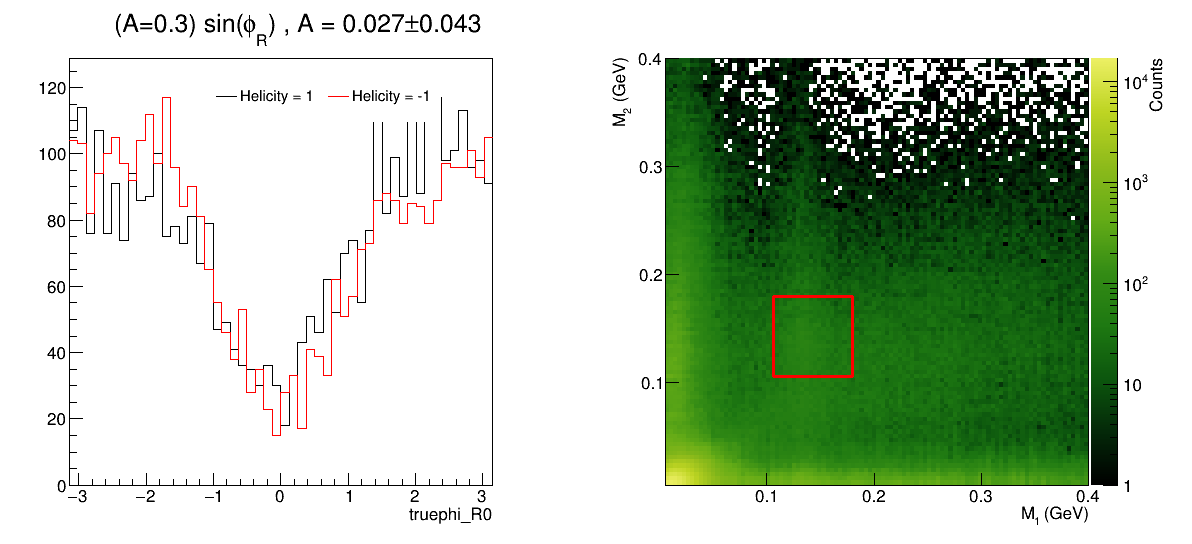

In [209]:
canvas=gen_dist("truephi_R0","","M1>0.106&&M1<0.18&&M2>0.106&&M2<0.18",Nmax=1e6)
canvas.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


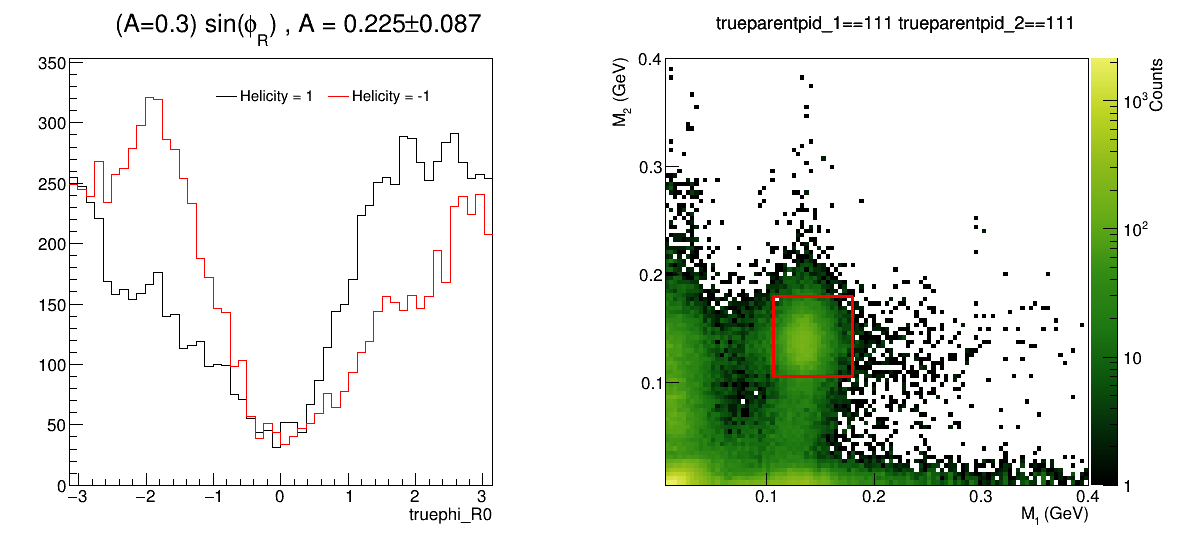

In [212]:
canvas=gen_dist("truephi_R0","trueparentpid_1==111&&trueparentpid_2==111","M1>0.106&&M1<0.18&&M2>0.106&&M2<0.18",1e7)
canvas.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


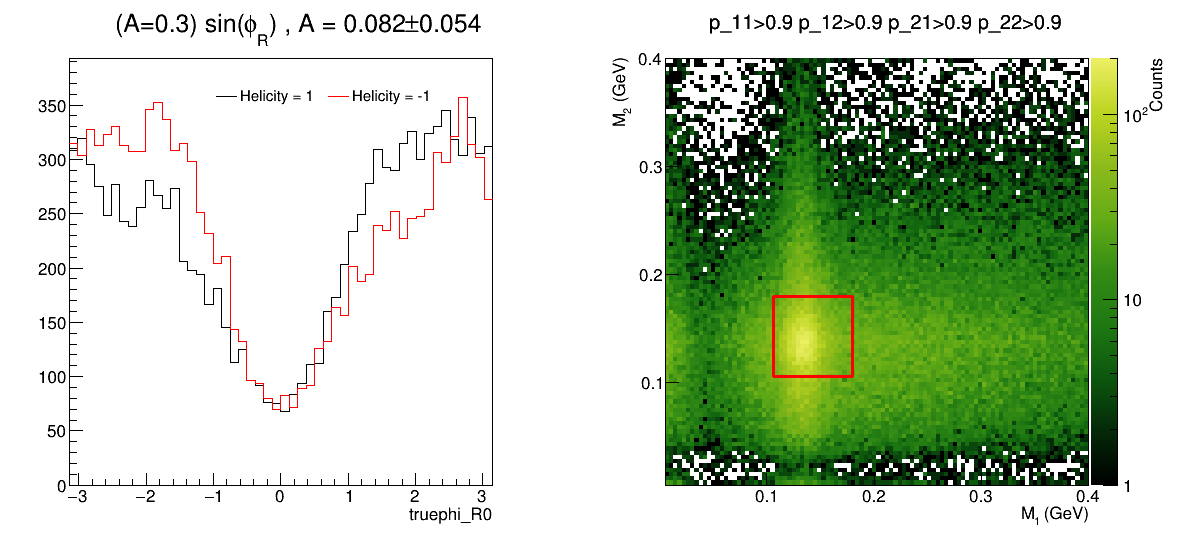

In [214]:
canvas=gen_dist("truephi_R0","p_11>0.9&&p_12>0.9&&p_21>0.9&&p_22>0.9","M1>0.106&&M1<0.18&&M2>0.106&&M2<0.18",1e7)
canvas.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


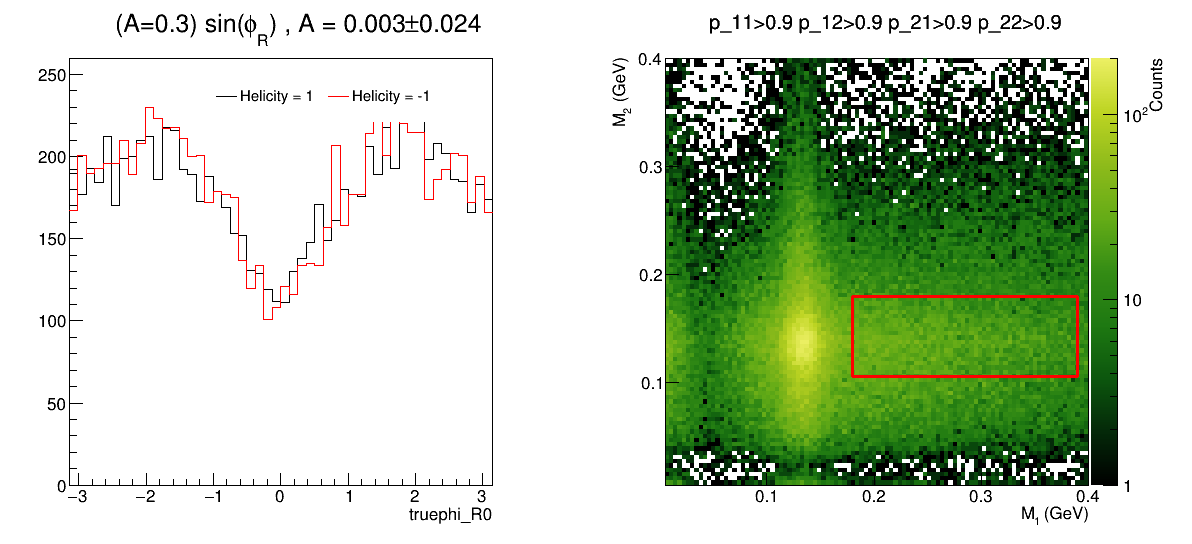

In [215]:
canvas=gen_dist("truephi_R0","p_11>0.9&&p_12>0.9&&p_21>0.9&&p_22>0.9","M1>0.18&&M1<0.39&&M2>0.106&&M2<0.18",1e7)
canvas.Draw()

In [217]:
0.082*3

0.246